Author: Adrian Swartz<br>
Date: 3/29/2019


# Solutions to Andew Ng's coursera problems
## Example 7a: K-means - unsupervised learning and data compression

Andrew Ng's course is designed for the solutions to be worked through in Octave (similar to matlab). However, I am going to do these problems in python (within a jupyter notebook) and demonstrate how various approaches can be implemented in python.

In this exercise, we are tasked with implementing K-means clustering and apply it to compress an image. 

This notebook is structured as follows:<br>

[Part 1 - Setting up K-means](#pt1)<br>
1. [Exploratory Data Analysis](#eda)
2. [Finding Closest Centroids Manually](#fcc)
3. [Computing Centroid Means](#ccm)
4. [Running K-means](#rkm)
5. [Evaluating kmeans](#eval)
6. [K-means with sklearn](#sklearn)
7. [Evaluating kmeans with sklearn](#eval2)
8. [Runtime Comparison](#rt)

[Part 2 - K-means for Image Compression](#pt2)<br>

***

For this exercise, we will import several python packages: NumPy (numerical python for matrix manupulations and advanced math), pandas (DataFrames offer a useful platform for importing data and performing exploratory data analysis), matplotlib and seaborn for data visualization.

In [1]:
# Import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
cp=sns.color_palette()

# import a few special packages we'll use for this example
from scipy.io import loadmat
from sklearn.cluster import KMeans

<a id="pt1"></a>
# Part 1 - Setting up K-means

Prompt:<br>
Start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works.

The K-means algorithm is a method to automatically cluster similar data examples together.

The intuition behind K-means is an iterative procedure that starts by guess- ing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

We are instructed to write the k-means algorithm as follows:

> // Initialize centroids<br>
> centroids = kMeansInitCentroids(X, K);<br>
> for iter = 1:iterations<br>
>>    // Cluster assignment step: Assign each data point to the closest centroid.<br>
>>    // idx(i) corresponds to cˆ(i), the index of the centroid assigned to example i<br>
>>    idx = findClosestCentroids(X, centroids);<br>
>>    // Move centroid step: Compute means based on centroid assigments<br>
>>    centroids = computeMeans(X, idx, K);<br>

The inner-loop of the algorithm repeatedly carries out two steps: (i) Assigning each training example $x^{(i)}$ to its closest centroid, and (ii) Recomputing the mean of each centroid using the points assigned to it. The K-means algorithm will always converge to some final set of means for the centroids. Note that the converged solution may not always be ideal and depends on the initial setting of the centroids. Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).


***

<a id="eda"></a>
# Exploratory Data Analysis

K-means is an algorithm aimed at finding structure (clusters according to the euclidean distance in feature space) in unlabled data. This is unsupervised machine learning.

In [2]:
raw_data = loadmat('ex7/ex7data2.mat')
data = pd.DataFrame(raw_data['X'], columns = ['X1','X2'])
data.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
X1    300 non-null float64
X2    300 non-null float64
dtypes: float64(2)
memory usage: 4.8 KB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
X1,300.0,3.684376,1.925578,-0.245127,2.156202,3.231561,5.50949,8.203398
X2,300.0,2.987101,1.685078,0.205810,1.210797,2.949738,4.80778,5.784297


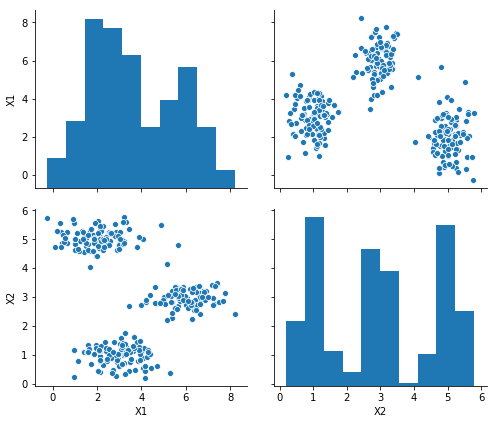

In [5]:
ax=sns.pairplot(data, height=3, aspect=1.2)

<a id="fcc"></a>
# Finding Closest Centroids Manually

Following the `ex7.pdf` prompt, we begin the process of implementing k-means manually by writing the function for finding the closest centroid for the complete set of data. 


In the “cluster assignment” phase of the K-means algorithm, the algorithm assigns every training example to its closest centroid, given the current positions of centroids.

The `find_closest_centroids` function takes the data matrix $X$ and the locations of all centroids inside centroids and should output a one-dimensional array idx that holds the index (a value in {1,...,$K$}, where $K$ is total number of centroids) of the closest centroid to every training example.

In [6]:
X = raw_data['X']

In [7]:
def find_closest_centroids(X, centroids):
    """ Find the the index of the data (X) closes to each of the k centroids
    input
    X: mxn matrix; the data
    centroids: kxn matrix; the n-dimensional positions of the k clusters 
    
    output
    idx: an integer array of length n; indices correspond with the closest of the k clusters   
    """
    M = len(X)
    k = len(centroids)
    idx = np.zeros(M)
    
    
    min_x1 = np.min(X[:,0])
    min_x2 = np.min(X[:,1])
    max_x1 = np.max(X[:,0])
    max_x2 = np.max(X[:,1])
    
    #Biggest distance that we are likely to have in feature space
    data_range = np.sum((np.array([min_x1,min_x2]) - np.array([max_x1,max_x2]))**2)
    
    for i in range(M):
        
        # initialize minimum distance to 100x that biggest distance in the data
        min_dist = 100*data_range 
        
        # for each data point, find the closest centroid
        for j in range(k):         
            # calc distance to centroid
            distance = np.sum((X[i,:] - centroids[j,:]) ** 2)   
            
            # chose the index which has the smallest distance
            if distance < min_dist:
                min_dist = distance
                idx[i] = j          
    
    return idx

In [8]:
initial_centroids = np.array([[0, 0], [6, 2], [8, 5]])

idx = find_closest_centroids(X, initial_centroids)
idx[0:10]

array([1., 2., 1., 1., 1., 0., 1., 1., 1., 1.])

In [9]:
%%timeit -n 20
find_closest_centroids(X, initial_centroids)
#it's pretty slow. I wonder if there's a way to speed it up. 
#At the moment, I don't see a faster way to write it.

9.28 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 20 loops each)


In [10]:
np.where(idx == 1) # which indices for the data belong to cluster 1

(array([  0,   2,   3,   4,   6,   7,   8,   9,  10,  11,  13,  15,  16,
         17,  19,  21,  22,  25,  26,  30,  31,  32,  33,  34,  35,  37,
         38,  40,  41,  42,  45,  46,  47,  49,  50,  51,  52,  53,  54,
         55,  58,  61,  64,  66,  68,  69,  70,  73,  74,  81,  82,  83,
         85,  86,  87,  89,  90,  91,  93,  94,  95,  96,  99, 100, 101,
        102, 104, 105, 106, 107, 109, 113, 114, 116, 118, 120, 121, 122,
        123, 124, 125, 127, 130, 131, 133, 138, 139, 140, 141, 142, 143,
        144, 145, 146, 147, 151, 158, 159, 160, 161, 163, 164, 169, 171,
        173, 174, 176, 177, 180, 183, 184, 185, 186, 187, 189, 191, 193,
        196, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212,
        213, 214, 215, 216, 217, 219, 220, 221, 222, 223, 224, 225, 226,
        227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239,
        240, 241, 242, 244, 246, 247, 248, 249, 250, 251, 252, 253, 254,
        255, 256, 257, 258, 259, 260, 261, 262, 263

<a id="ccm"></a>
# Computing Centroid Means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it.

In [11]:
def compute_centroid_means(X, idx, k):
    """ Compute the the mean of the points that were assigned to each cluster
    input
    X: mxn matrix; the data
    idx: an integer array of length n; indices correspond with the closest of the k clusters
    k: an integer; number of clusters
    
    output
    centers: a kxn matrix; the mean positions for the data assigned to each cluster
    """
    M, N = X.shape
    centers = np.zeros((k, N))
    
    for i in range(k):
        indices = np.where(idx == i)
        centers[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centers

cpts = compute_centroid_means(X, idx, 3)
cpts

array([[1.69824172, 2.73725406],
       [4.34033363, 3.05285776],
       [6.80062351, 3.88668776]])

In [12]:
indices = np.where(idx == 0)
np.mean(X[indices],axis=0)

array([1.69824172, 2.73725406])

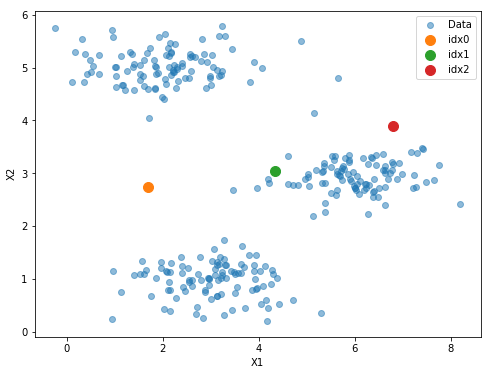

In [13]:
# plotting the centroids calculated for a single initialization case

fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(data.X1,data.X2,label='Data',alpha=0.5)
plt.scatter(cpts[0,0],cpts[0,1],s=100,label='idx0')
plt.scatter(cpts[1,0],cpts[1,1],s=100,label='idx1')
plt.scatter(cpts[2,0],cpts[2,1],s=100,label='idx2')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.legend()

<a id="rkm"></a>
# Running K-means

In [14]:
def run_kmeans(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroid_means(X, idx, k)
    
    return idx, centroids

idx, centroids = run_kmeans(X, initial_centroids, 10)

Remember that we cannot initialize the starting centers to zero. Here are several diferent ways of initializing centroids.

In [15]:

def initialize_centroids(X, k):
    N = X.shape[1]
    
    min_x1 = np.min(X[:,0])
    min_x2 = np.min(X[:,1])
    max_x1 = np.max(X[:,0])
    max_x2 = np.max(X[:,1])
    
    mn = min(min_x1,min_x2)
    mx = max(max_x1,max_x2)+1
    
    return np.random.randint(mn, high=mx, size=(k,N))

def initialize_random_centroids(X, k):
    m, n = X.shape
    initial_centroids = np.random.rand(k,n)
    
    for i in range(n):
        scale = np.max(X[:,i]) - np.min(X[:,i])
        initial_centroids[:,i]*=scale
    return initial_centroids


#I'll use this one. Initialize based on taking a points from the data at random
def initialize_Xrandom_centroids(X, k):
    m, n = X.shape
    initial_centroids = np.zeros((k,n))
    
    for i in range(k):
        for j in range(n):
            initial_centroids[i,j] = np.random.choice(np.asarray(X[:,j]).reshape(-1))
    return initial_centroids

In [16]:
init_c = initialize_Xrandom_centroids(X, 3)
init_c

array([[0.96791348, 0.69438336],
       [5.72395697, 2.88845269],
       [0.99253246, 5.03153948]])

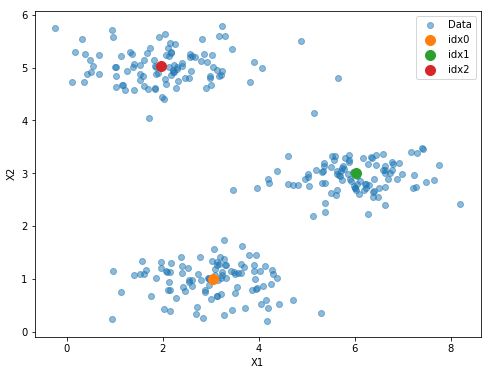

In [17]:
idx_result, cpts_result = run_kmeans(X,init_c,20)

fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(data.X1,data.X2,label='Data',alpha=0.5)
plt.scatter(cpts_result[0,0],cpts_result[0,1],s=100,label='idx0')
plt.scatter(cpts_result[1,0],cpts_result[1,1],s=100,label='idx1')
plt.scatter(cpts_result[2,0],cpts_result[2,1],s=100,label='idx2')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.legend()

In [18]:
cluster0 = pd.DataFrame(X[np.where(idx_result == 0)], columns = ['X1','X2'])
cluster1 = pd.DataFrame(X[np.where(idx_result == 1)], columns = ['X1','X2'])
cluster2 = pd.DataFrame(X[np.where(idx_result == 2)], columns = ['X1','X2'])
cluster0.head()

,X1,X2
0,3.203606,0.722215
1,3.061929,1.571921
2,4.017149,1.160706
3,1.402608,1.087265
4,4.081650,0.872003


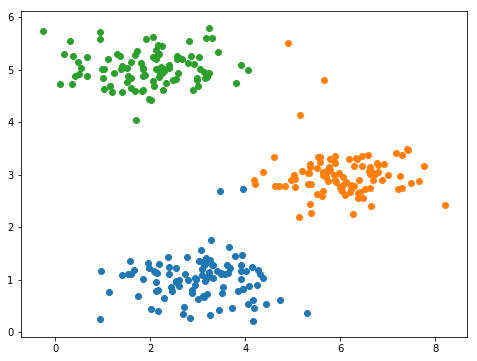

In [19]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(cluster0.X1,cluster0.X2)
plt.scatter(cluster1.X1,cluster1.X2)
plt.scatter(cluster2.X1,cluster2.X2)

<a id="eval"></a>
# Evaluating kmeans
It Works! But how do we know how well it was converging on finding the best clusters and how robust is the result to different initializations?  To answer these questions, we'll need to have some kind of measure of quality of the clustering of the data. Enter a "cost" function.

In [20]:
def cost_function(X, idx, centroids):
    """ Sum of squared distances of samples to their closest cluster center
    In sklearn this is called inertia_
    input
    X: mxn matrix; the data
    idx: an integer array of length n; indices correspond with the closest of the k clusters
    centroids: a kxn matrix; the positions for the k clusters
    
    output
    cost: a float; Sum of squared distances of samples to their closest cluster center
    """
    
    M = len(X)
    k = len(centroids)
    
    cost = 0
    for i in range(k):

        indices = np.where(idx == i)        
        cost = np.sum(np.linalg.norm(X[indices]-centroids[i]))

    return cost

In [21]:
#test that it works!
cost_function(X, idx_result, cpts_result)

9.566283714107351

Now that we have a measure of the distance of each data point to it's assigned cluster, we can __calculate the cost for different initializations.__  Here I'm looking for reproducibility.

In [22]:
x = range(100)
costs = []
running_centroids = []
iterations=5
for i in x:
    init_c = initialize_Xrandom_centroids(X, 3)
    idx_result, cpts_result = run_kmeans(X, init_c, iterations)
    
    running_centroids.append(cpts_result)
    costs.append(cost_function(X, idx_result, cpts_result))



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


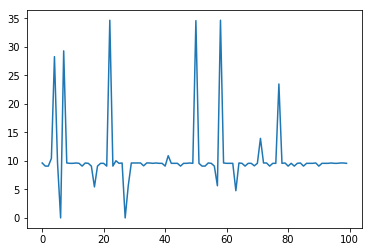

In [23]:
plt.plot(x,costs)

(array([ 2.,  4., 85.,  2.,  1.,  0.,  1.,  0.,  2.,  3.]),
 array([ 0.        ,  3.46398418,  6.92796836, 10.39195255, 13.85593673,
        17.31992091, 20.78390509, 24.24788928, 27.71187346, 31.17585764,
        34.63984182]),
 <a list of 10 Patch objects>)

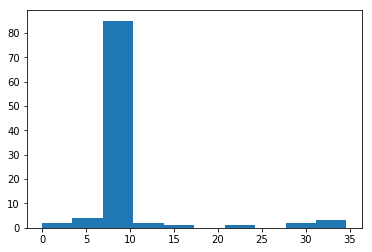

In [24]:
plt.hist(costs, bins=10)

$\approx$85% of the time it initializes a condition for which k-means is capable of finding the optimal clusters. 

In [25]:
np.where(costs == min(costs))

(array([ 6, 27]),)

In [52]:
c = running_centroids[6]
c

array([[3.03033557, 0.98166827],
       [4.01139559, 3.98981706],
       [       nan,        nan]])

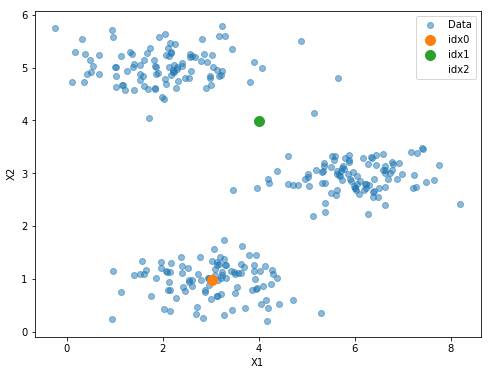

In [53]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(data.X1,data.X2,label='Data',alpha=0.5)
plt.scatter(c[0,0],c[0,1],s=100,label='idx0')
plt.scatter(c[1,0],c[1,1],s=100,label='idx1')
plt.scatter(c[2,0],c[2,1],s=100,label='idx2')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.legend()

You can see that k-means (and the "cost" metric) doesn't work quite right all the time. It likes to find a low cost when there isn't a third cluster (or when two centroids end up close to each other on the same cluster) while one centroid splits two far away clusters. This is an problem with how the "cost" is calculated. Possibly sklearn's kmeans inertia_ is more robust compared to my home-made algorithm. We'll take a look shortly. 

Let's also look at the my k-means algorithm's efficiency at converging on a solution.

In [28]:
iterations = range(1,50)
costs = []
init_c = initialize_Xrandom_centroids(X, 3)
for i in iterations:
    idx_result, cpts_result = run_kmeans(X, init_c, i)
    
    running_centroids.append(cpts_result)
    costs.append(cost_function(X, idx_result, cpts_result))

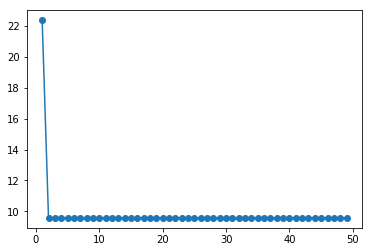

In [29]:
plt.plot(iterations,costs,'-o')
# Seems to converge within just a couple of iterations.

That sure took a bit of effort to calculate all the centroids/means, and to figure out how long it takes to converge.  For more data with a large number of features where it's harder to visualize the clusters, we would need to carefully track the initialization repeatability and the convergence as a function of iterations. That would be slighly painful to do manually! That's why we don't write our own k-means! We use sklearn!

<a id="sklearn"></a>
# K-means with sklearn

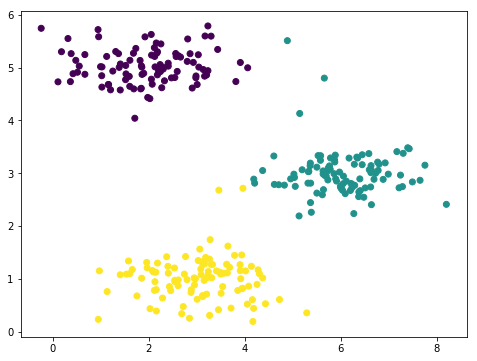

In [30]:
y_pred = KMeans(n_clusters=3).fit_predict(X)

fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(data.X1, data.X2, c=y_pred)

sklearn sure is awesome! No surprise!

In [31]:
result = KMeans(n_clusters=3).fit(X)
cpts=result.cluster_centers_

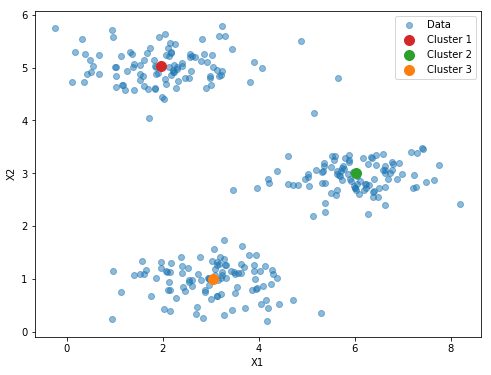

In [32]:
fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(data.X1, data.X2, label='Data',alpha=0.5)
plt.scatter(cpts[0,0],cpts[0,1],color=cp[3], s=100, label='Cluster 1')
plt.scatter(cpts[1,0],cpts[1,1],color=cp[2], s=100, label='Cluster 2')
plt.scatter(cpts[2,0],cpts[2,1],color=cp[1], s=100, label='Cluster 3')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.legend()

sklearn is awesome! No surprise!

<a id="eval2"></a>
# Evaluating kmeans with sklearn

OK. Let's check how good it is at finding the best result with different initializations


In [33]:
km = KMeans(n_clusters=3, init='random', n_init=1, tol=.1)
km.fit_predict(X)
km.inertia_

266.73886486981957

(array([89.,  0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  1.]),
 array([ 266.65851965,  364.06362679,  461.46873392,  558.87384106,
         656.27894819,  753.68405533,  851.08916246,  948.4942696 ,
        1045.89937673, 1143.30448387, 1240.709591  ]),
 <a list of 10 Patch objects>)

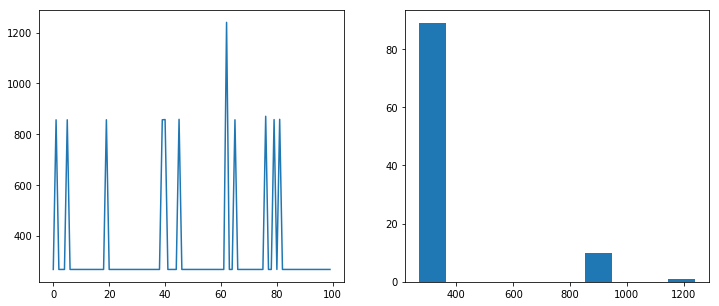

In [34]:
x = range(100)
inertias = []
for i in x:
    km = KMeans(n_clusters=3, init='random', n_init=1, tol=.01, max_iter=20)
    km.fit_predict(X)
    inertias.append(km.inertia_)

fix, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(x,inertias)
ax2.hist(inertias)

With these hyperparameters k-means reaches an optimal solution $\approx$85% of the time. Here I have tried to reproduce my homemade k-means by controlling the KMeans hyperparameters. I have sampled randomly from $X$ using `init='random'`, limit the number of times KMeans will run with different centroid seeds (`n_init=1`), and limited the `max_iter` to 20. Clearly it conveges.

However, KMeans has several optimized techniques which we can control via the hyperparameters.

(array([99.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([266.65851965, 325.73355995, 384.80860025, 443.88364054,
        502.95868084, 562.03372114, 621.10876143, 680.18380173,
        739.25884202, 798.33388232, 857.40892262]),
 <a list of 10 Patch objects>)

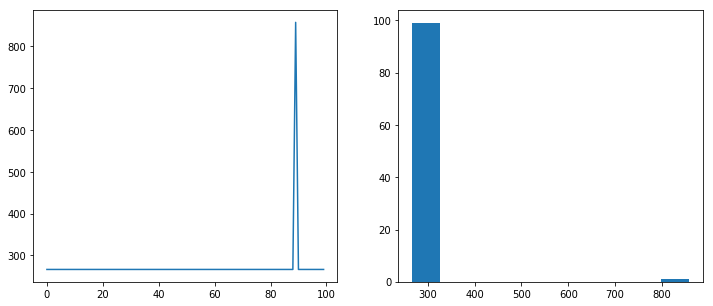

In [35]:
x = range(100)
inertias = []
for i in x:
    km = KMeans(n_clusters=3, init='k-means++', n_init=1, tol=.01, max_iter=20)
    km.fit_predict(X)
    inertias.append(km.inertia_)

fix, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(x,inertias)
ax2.hist(inertias)

Look at that.  `'k-means++' : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.` There's not much more information in the documentaiton than that, but it converges extremely well with this specialized initialization setting. 

<a id="rt"></a>
# Runtime comparison

Let's look at the time it takes to run these different algorithms.

In [36]:
%%timeit -n 10
run_kmeans(X, init_c, 20)

162 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
%%timeit -n 100
KMeans(n_clusters=3, init='random', n_init=1, tol=.01, max_iter=20).fit(X)

1.31 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [38]:
%%timeit -n 100
KMeans(n_clusters=3, init='k-means++', n_init=1, tol=.01, max_iter=20).fit(X)

1.61 ms ± 93.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
%%timeit -n 10
#Let's check the default. 
KMeans(n_clusters=3).fit(X)

23.2 ms ± 8.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The sklearn default setting is way faster then my implementation, but slower than if I had set n_init=1. However, notice that n_init=1 gives a pretty good solution. Depending on the data complexity this could be a good way to speed up the learning time. 
<a id="pt2"></a>
# Part 2 - K-means for Image Compression

In this exercise, you will apply K-means to image compression. In a straightforward 24-bit color representation of an image,2 each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) that specify the red, green and blue intensity values. This encoding is often refered to as the RGB encoding. Our image contains thousands of colors, and in this part of the exercise, you will reduce the number of colors to 16 colors.

# Let's look at the data

In [40]:
image_data = loadmat('ex7/bird_small.mat')
image_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Jun  5 04:06:24 2012',
 '__version__': '1.0',
 '__globals__': [],
 'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ...,
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ...,
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ...,
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ...,
 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ...,
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ...,
         [ 80,  38,  40],
         [ 68,  39,  40],
     

In [41]:
A = image_data['A']
A.shape

(128, 128, 3)

In [42]:
A[50, 33, 2]

50

In [43]:
np.min(A), np.max(A)

(6, 255)

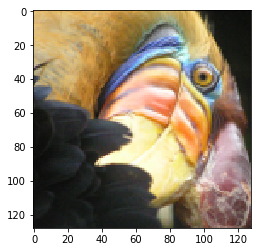

In [44]:
plt.imshow(A)

<a id="pre"></a>
# Preprocess the Image Data

In [45]:
#Normalize the data
A_norm = A/255.0

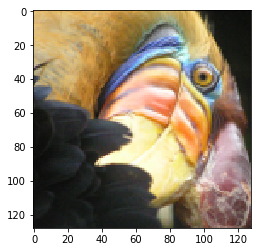

In [46]:
plt.imshow(A_norm)

In [47]:
np.min(A_norm), np.max(A_norm)

(0.023529411764705882, 1.0)

In [48]:
# reshape the array
X = np.reshape(A_norm, (A_norm.shape[0] * A_norm.shape[1], A_norm.shape[2]))

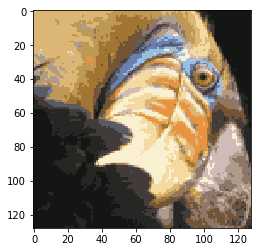

In [49]:
result = KMeans(n_clusters=16).fit(X)
centroids=result.cluster_centers_
idx = find_closest_centroids(X, centroids)

# Recover the image and reshape into 128x128 pixels
X_recovered = centroids[idx.astype(int),:]
X_recovered = np.reshape(X_recovered, (A_norm.shape[0], A_norm.shape[1], A_norm.shape[2]))


plt.imshow(X_recovered)

__What would it look like if we made the image binary?__

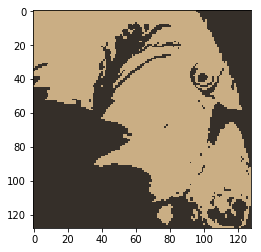

In [50]:
result = KMeans(n_clusters=2).fit(X)
centroids=result.cluster_centers_
idx = find_closest_centroids(X, centroids)

# Recover the image and reshape into 128x128 pixels
X_recovered = centroids[idx.astype(int),:]
X_recovered = np.reshape(X_recovered, (A_norm.shape[0], A_norm.shape[1], A_norm.shape[2]))


plt.imshow(X_recovered)

Hard to see by eye what that is. What a about 4 colors?

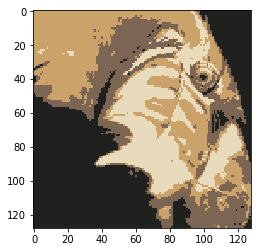

In [51]:
result = KMeans(n_clusters=4).fit(X)
centroids=result.cluster_centers_
idx = find_closest_centroids(X, centroids)

# Recover the image and reshape into 128x128 pixels
X_recovered = centroids[idx.astype(int),:]
X_recovered = np.reshape(X_recovered, (A_norm.shape[0], A_norm.shape[1], A_norm.shape[2]))


plt.imshow(X_recovered)

K Means is pretty effective at reducing the information we had before. While k-means can often be used for segmenting problems (i.e. finding out structure in your customer base), k-means also allows us to assign continuous data distributions into a digitized form of k-clusters. This is essentially removing information from the data - compression.  On to another data reduction technique: Principle component analysis.